In [3]:
#import library 
import os
import shutil
import random 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import DataLoader


from torch import nn
from helper_functions import set_seeds


In [27]:
#using same method to split dataset into test,train,and validate 
#test 
# Set the main directory
main_directory = "bloodcells_data"
maincat_directory = "bloodcells_dataset"


# Create train and test directories
train_directory = os.path.join(main_directory, "train")
test_directory = os.path.join(main_directory, "test")
val_directory = os.path.join(main_directory, "valid")
notused_directory = os.path.join(main_directory, "not_used")
# Iterate through each category
for category in os.listdir(maincat_directory):
    category_path = os.path.join(maincat_directory, category)
    
    # Create subdirectories for each category
    train_category_path = os.path.join(train_directory, category)
    test_category_path = os.path.join(test_directory, category)
    val_category_path = os.path.join(val_directory, category)
    notused_category_path = os.path.join(notused_directory, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(val_category_path, exist_ok=True)
    os.makedirs(notused_category_path, exist_ok=True)
    #list of all images in the category
    images = os.listdir(category_path)
    
    # Take 20% of category of random images for the test 
    
    test_images = random.sample(images, 50)

    #take 10 images for validation set 
    val_images = random.sample(images, 10)

    train_images = random.sample(images, 100)        #*** had to take smaller samples of the dataset for train/test because my computer could not handle the amount of data it contained - it would not train
    
    for image in images:
        image_path = os.path.join(category_path, image)
        
        # Copy images to train or test directory based on the split
        if image in test_images:
            shutil.copy(image_path, os.path.join(test_category_path, image))
        elif image in val_images:
            shutil.copy(image_path, os.path.join(val_category_path, image))
        elif image in train_images:
            shutil.copy(image_path, os.path.join(train_category_path, image))
        else:
            shutil.copy(image_path, os.path.join(notused_category_path, image))

print("Dataset split into train and test sets")


Dataset split into train and test sets


In [28]:


# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [31]:
# Setup pretrained model - using ResNet based on literature 

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)
transform = weights.transforms()

print(transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [32]:

# Use ImageFolder to create the train, val and test data

train = 'bloodcells_data/train'
test = 'bloodcells_data/test'
val = 'bloodcells_data/valid'

train_data = datasets.ImageFolder(train,transform=transform)
valid_data = datasets.ImageFolder(val,transform=transform)
test_data = datasets.ImageFolder(test, transform=transform)

In [33]:
# Create dataloaders for test, val and train sets 
num_workers = 8
batch_size = 16

class_names = train_data.classes
print(f"Classes in this dataset: {class_names}")

train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
valid_dataloader = DataLoader(valid_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)

Classes in this dataset: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [34]:
# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False

num_classes = len(class_names)

# change last layer 
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)


In [35]:
from torchinfo import summary

# Print a summary 
summary(model=model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [36]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), lr=.0001)
loss_fn = nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
results = engine.train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=3,
                                      device=device)

 33%|███▎      | 1/3 [04:22<08:45, 262.86s/it]

Epoch: 1 | train_loss: 2.0611 | train_acc: 0.1767 | test_loss: 2.0119 | test_acc: 0.3400


 67%|██████▋   | 2/3 [08:48<04:24, 264.21s/it]

Epoch: 2 | train_loss: 1.9968 | train_acc: 0.3808 | test_loss: 1.9532 | test_acc: 0.5375


100%|██████████| 3/3 [13:31<00:00, 270.45s/it]

Epoch: 3 | train_loss: 1.9374 | train_acc: 0.5474 | test_loss: 1.8997 | test_acc: 0.6325


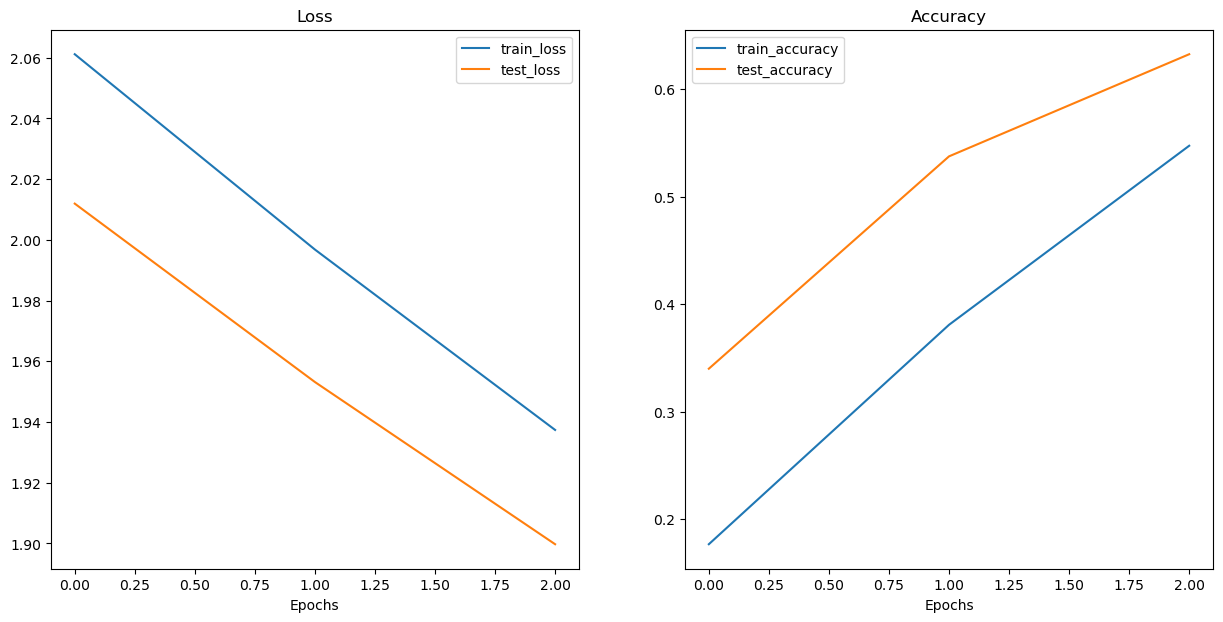

In [37]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(results) 

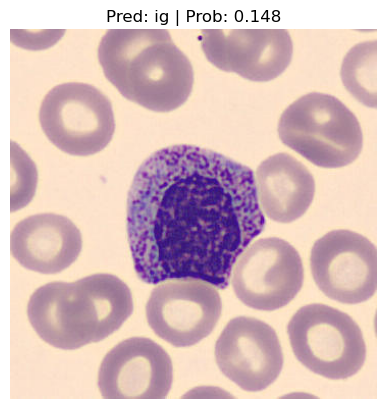

In [38]:
import requests
import os
import random
from pathlib import Path

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup image path

#number of images collected to test
sample = 1
data = "bloodcells_data/valid"

testlist = list(Path(data).glob("*/*.jpg")) 
#randomly select 1 images from the list of all of the test images that were set aside (1 of each) 
testsample = random.sample(population=testlist, k=sample)


# Predict on custom image
for image_path in testsample:
    pred_and_plot_image(model=model,
                    image_path=image_path,
                    class_names=class_names,
                    transform=weights.transforms(),)